# Exploration

## Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random 

In [2]:
charges = pd.read_csv("Courbes de charge_optis.csv",sep=";")
charges["Date"]=pd.to_datetime(charges["Date"],format="%d/%m/%Y %H:%M")
print("Les données")
charges.head(5)

Les données


,Fluid,Date,Power,Meter_ID
0,Electricity,2022-03-23 00:00:00,165,F
1,Electricity,2022-03-23 00:10:00,168,F
2,Electricity,2022-03-23 00:20:00,170,F
3,Electricity,2022-03-23 00:30:00,166,F
4,Electricity,2022-03-23 00:40:00,97,F


In [3]:
res = pd.read_excel("Template_resultats.xlsx")
res.set_index("meter_id",drop=True,inplace=True)
print("L'excel de rendu")
res

L'excel de rendu


,Code postal,Date de début,Date de fin,Actuel : tarif,Actuel : Facture glissante (€ HT),Actuel : Puissance souscrite POINTE,Puissance souscrite hph actuelle (kVA C4 / kW C3-C1),Puissance souscrite hch actuelle (kVA C4 / kW C3-C1),Puissance souscrite hpe actuelle (kVA C4 / kW C3-C1),Puissance souscrite hce actuelle (kVA C4 / kW C3-C1),...,Consommation kwh hph réelle,Actuel : Consommation POINTE (kWh),Préconisation : tarif,Préconisation : Facture glissante (€ HT),Puissance souscrite pointe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hph optimisée (kVA C4 / kW C3-C1),Puissance souscrite hch optimisée (kVA C4 / kW C3-C1),Puissance souscrite hpe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hce optimisée (kVA C4 / kW C3-C1),Gains euros
meter_id,,,,,,,,,,,,,,,,,,,,,
B,39015,NaN,NaN,HTA pointe fixe LU,NaN,500,500,500,500,500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D,58220,NaN,NaN,HTA pointe fixe LU,NaN,130,130,130,130,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,58000,NaN,NaN,HTA pointe fixe LU,NaN,1530,1530,1530,1710,1710,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G,25600,NaN,NaN,HTA pointe fixe LU,NaN,300,300,300,300,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,58230,NaN,NaN,HTA pointe fixe CU,NaN,61,61,61,61,61,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E,25290,NaN,NaN,HTA pointe fixe CU,NaN,123,123,350,350,350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,90000,NaN,NaN,HTA pointe fixe LU,NaN,66,410,410,410,410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ajouter les dates de débuts et de fin des compteurs

In [4]:
def update_date(res=res,meter_id="A"):
    #
    temp = charges[charges["Meter_ID"]==meter_id].sort_values(by="Date")
    res.loc[meter_id,"Date de début"]=temp.iloc[0].loc["Date"]
    res.loc[meter_id,"Date de fin"]=temp.iloc[-1].loc["Date"]
    
for letter in res.index:
    update_date(meter_id=letter)
res.loc[:,["Date de début","Date de fin"]]

,Date de début,Date de fin
meter_id,,
B,2022-03-23 00:00:00,2023-02-23 23:50:00
D,2022-03-23 00:00:00,2023-02-23 23:50:00
A,2022-03-23 00:00:00,2023-02-23 23:50:00
G,2022-03-23 00:00:00,2023-02-23 23:50:00
C,2022-03-23 00:00:00,2023-02-23 23:50:00
E,2022-03-23 00:00:00,2023-02-23 23:50:00
F,2022-03-23 00:00:00,2023-02-23 23:50:00


## Differents profils

![alt text](images/profils.png "Title")


Jettons un coups d'oeil aux différent profil de compteur que nous avons

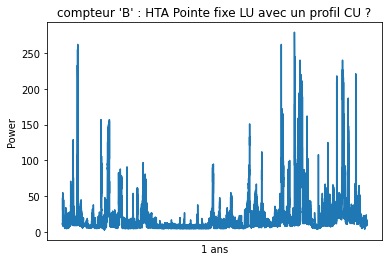

In [5]:
temp = charges[charges["Meter_ID"]=="B"].sort_values(by="Date")
plt.plot(temp["Power"])
plt.ylabel("Power")
plt.xticks([])
plt.xlabel("1 ans")
plt.title("compteur 'B' : HTA Pointe fixe LU avec un profil CU ?");


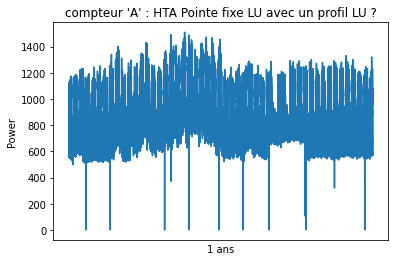

In [6]:
temp = charges[charges["Meter_ID"]=="A"].sort_values(by="Date")
plt.plot(temp["Power"])
plt.ylabel("Power")
plt.xticks([])
plt.xlabel("1 ans")
plt.title("compteur 'A' : HTA Pointe fixe LU avec un profil LU ?");

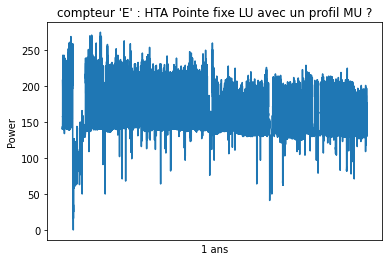

In [7]:
temp = charges[charges["Meter_ID"]=="G"].sort_values(by="Date")
plt.plot(temp["Power"])
plt.ylabel("Power")
plt.xticks([])
plt.xlabel("1 ans")
plt.title("compteur 'E' : HTA Pointe fixe LU avec un profil MU ?");

# Heures & Saisons

## Labelling

![alt text](images/heures.png "Title")


La courbe de charge définit l’évolution de la consommation d’énergie pendant une durée (1 heure, 1 minutes, 10 secondes…), et donc de la puissance électrique que  consommé pendant une durée fixe. Elle est constituée d'un relevé de la consommation électrique du client à intervalles réguliers (le pas de mesure).

Pour simplifier les jours féries n'ont pas été pris en compte 

In [8]:
# Nomenclature 
# "HP" Heure Pointe
# "HPH" Heure pleine Haute Saison (Hiver)
# "HCH" Heure Creuse Haute Saison (Hiver)
# "HPE" Heure Pleine Basse Saison (Eté)
# "HCE" Heure Creuse Basse Saison (Eté)

In [9]:
def is_weekend(day):
    '''Return True if the day is not a bussness day'''
    # TODO vacances françaises ?
    return not bool(len(pd.bdate_range(start=day,end=day)))

start = pd.to_datetime("2023-04-24")
is_weekend(start)

False

In [10]:
def get_hour_tarif(date):
    # (Saison haute)
    if date.month in [1,2,3,11,12]:
        
        if is_weekend(date): return "HCH"
        
        if date.month not in [3,11] and date.hour in [9,10,18,19]: return "HP"
        
        if date.hour in [0,1,2,3,4,5,6,23] : return "HCH"
        
        else : return "HPH"
            
    # (Basse Saison)
    if is_weekend(date) : 
        return "HCE"
    
    if date.hour in list(range(7,23)) : return "HPE"
    else : return "HCE"
        
ex = datetime.datetime(2222,4,12,11)

print("Fonction de Classification des heures, exemple : ")
print(ex)
print("La catégorie est ")
get_hour_tarif(ex)

Fonction de Classification des heures, exemple : 
2222-04-12 11:00:00
La catégorie est 


'HPE'

In [11]:
# Random tests
import random
n= random.randint(0,(len(charges)))
ex = charges.iloc[n]["Date"]
print(ex)
get_hour_tarif(ex)

2022-08-15 01:10:00


'HCE'

In [12]:
print("Rajout de la colomne Hour_code ")

charges["Hour_code"] = charges.Date.apply(get_hour_tarif)

charges

Rajout de la colomne Hour_code 


,Fluid,Date,Power,Meter_ID,Hour_code
0,Electricity,2022-03-23 00:00:00,165,F,HCH
1,Electricity,2022-03-23 00:10:00,168,F,HCH
2,Electricity,2022-03-23 00:20:00,170,F,HCH
3,Electricity,2022-03-23 00:30:00,166,F,HCH
4,Electricity,2022-03-23 00:40:00,97,F,HCH
...,...,...,...,...,...
355489,Electricity,2023-02-23 23:10:00,132,G,HCH
355490,Electricity,2023-02-23 23:20:00,132,G,HCH
355491,Electricity,2023-02-23 23:30:00,130,G,HCH
355492,Electricity,2023-02-23 23:40:00,131,G,HCH


## Calcul des puissances max atteinte 

In [13]:
def get_max_and_tot_puissance(meterid:str
                     ,charges:pd.DataFrame):
    temp = charges[charges["Meter_ID"]==meterid]
    #for code in ["HP","HPH","HCH","HPE","HCE"]:
    maxes = (temp.groupby(by="Hour_code").max()[["Power"]].rename(columns={"Power":"Max Power"}))
    #print(maxes.loc["HP","Max Power"])
    res.loc[meterid,"Actuel : Puissance max atteinte Pointe"]= maxes.loc["HP","Max Power"]
    res.loc[meterid,"Actuel : Puissance max atteinte HPH"]= maxes.loc["HPH","Max Power"]
    res.loc[meterid,"Actuel : Puissance max atteinte HCH"]= maxes.loc["HCH","Max Power"]
    res.loc[meterid,"Actuel : Puissance max atteinte HCE"]= maxes.loc["HCE","Max Power"]
    res.loc[meterid,"Actuel : Puissance max atteinte HPE"]= maxes.loc["HPE","Max Power"]
    
    temp = charges[charges["Meter_ID"]==letter]
    temp.set_index("Date",drop=True,inplace=True)
    temp = temp.loc[:,["Power"]].resample("H").mean()
    temp["Date"]=temp.index
    temp["Hour_code"]= temp.Date.apply(get_hour_tarif)
    tot = temp.loc[:,["Power","Hour_code"]].groupby(by="Hour_code").sum()[["Power"]].rename(columns={"Power":"Total Power"})
    
    res.loc[meterid,"Actuel : Consommation POINTE (kWh)"]= tot.loc["HP","Total Power"]
    #print(E1)
    res.loc[meterid,"Consommation kwh hph réelle"] = tot.loc["HPH","Total Power"]
    #print(E2)
    res.loc[meterid,"Actuel : Consommation HCH (kWh)"] = tot.loc["HCH","Total Power"]
    #print(E3)
    res.loc[meterid,"Actuel : Consommation HPE (kWh)"] = tot.loc["HPE","Total Power"]
    #print(E4)
    res.loc[meterid,"Actuel : Consommation HCE (kWh)"] = tot.loc["HCE","Total Power"]
    #print(E5)
    
get_max_and_tot_puissance("B",charges)
for letter in res.index:
    get_max_and_tot_puissance(letter,charges)
res.loc[:,["Actuel : Puissance max atteinte HCE","Actuel : Consommation HCE (kWh)"]]

,Actuel : Puissance max atteinte HCE,Actuel : Consommation HCE (kWh)
meter_id,,
B,262.0,4.215950e+04
D,139.0,5.022267e+04
A,1132.0,1.926194e+06
G,270.0,4.134238e+05
C,120.0,5.071817e+04
E,132.0,1.856840e+05
F,391.0,3.710333e+05


In [14]:
res

,Code postal,Date de début,Date de fin,Actuel : tarif,Actuel : Facture glissante (€ HT),Actuel : Puissance souscrite POINTE,Puissance souscrite hph actuelle (kVA C4 / kW C3-C1),Puissance souscrite hch actuelle (kVA C4 / kW C3-C1),Puissance souscrite hpe actuelle (kVA C4 / kW C3-C1),Puissance souscrite hce actuelle (kVA C4 / kW C3-C1),...,Consommation kwh hph réelle,Actuel : Consommation POINTE (kWh),Préconisation : tarif,Préconisation : Facture glissante (€ HT),Puissance souscrite pointe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hph optimisée (kVA C4 / kW C3-C1),Puissance souscrite hch optimisée (kVA C4 / kW C3-C1),Puissance souscrite hpe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hce optimisée (kVA C4 / kW C3-C1),Gains euros
meter_id,,,,,,,,,,,,,,,,,,,,,
B,39015,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,NaN,500,500,500,500,500,...,2.994567e+04,8063.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D,58220,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,NaN,130,130,130,130,130,...,5.346917e+04,14194.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A,58000,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,NaN,1530,1530,1530,1710,1710,...,1.114749e+06,233570.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G,25600,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,NaN,300,300,300,300,300,...,2.002252e+05,42837.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,58230,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe CU,NaN,61,61,61,61,61,...,4.323550e+04,10488.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E,25290,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe CU,NaN,123,123,350,350,350,...,8.186783e+04,17311.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
F,90000,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,NaN,66,410,410,410,410,...,1.742085e+05,21112.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Couts Annuels

![alt text](images/formula.png "Title")


In [15]:
COST_COEFICIENTS = {
#Heures de Pointe Fixe(i=1),HPH(i=2),HCH(i=3), HPE(i=4), HCE (i=5)
    "HTA pointe fixe LU":{ #PF == Pointe Fixe
         "Puissance":[16.31,15.76,13.29,8.75,1.67] #b1, b2, b3, b4, b5
        ,"Energie":[2.85,2.14,1.34,0.99,0.87] #c1, c2, c3, c4, c5
    },
    "HTA pointe fixe CU":{
         "Puissance":[2.66,2.38,2.01,1.83,0.96]
        ,"Energie":[3.11,2.93,2.11,1.95,1.18]
    }
}

NB sur les puissances souscrites 
$$ PS1\leq PS2 \leq PS3 \leq PS4 \leq PS5 $$

$$PartFixe = b_1*PS_1 + \sum_{i=2}^5{b_i * (PS_i-PS_{i-1})} $$

Les $b_i$ sont les coefficient de puissance

In [16]:
def compute_fixed_cost(typedeFacturation
                      ,PS1
                      ,PS2
                      ,PS3
                      ,PS4
                      ,PS5):
    b1,b2,b3,b4,b5 = COST_COEFICIENTS[typedeFacturation]["Puissance"]
    return b1*PS1+b2*(PS2-PS1)+b3*(PS3-PS2)+b4*(PS4-PS3)+b5*(PS5-PS4)

# letter = "A"
# compute_fixed_cost(res.loc[letter,"Actuel : tarif"]
#                     ,res.loc[letter,'Actuel : Puissance souscrite POINTE']
#                     ,res.loc[letter,'Puissance souscrite hph actuelle (kVA C4 / kW C3-C1)']
#                     ,res.loc[letter,'Puissance souscrite hch actuelle (kVA C4 / kW C3-C1)']
#                     ,res.loc[letter,'Puissance souscrite hpe actuelle (kVA C4 / kW C3-C1)']
#                     ,res.loc[letter,'Puissance souscrite hce actuelle (kVA C4 / kW C3-C1)'])

$$ PartEnergie=\sum_{i=1}^5{c_i*E_i}$$

In [17]:
def compute_part_energie(typedeFacturation,charges,letter):
    c1,c2,c3,c4,c5 = COST_COEFICIENTS[typedeFacturation]["Energie"]
    temp = charges[charges["Meter_ID"]==letter]
    temp.set_index("Date",drop=True,inplace=True)
    temp = temp.loc[:,["Power"]].resample("H").mean()
    temp["Date"]=temp.index
    temp["Hour_code"]= temp.Date.apply(get_hour_tarif)
    tot = temp.loc[:,["Power","Hour_code"]].groupby(by="Hour_code").sum()[["Power"]].rename(columns={"Power":"Total Power"})
    E1 = tot.loc["HP","Total Power"]
    #print(E1)
    E2 = tot.loc["HPH","Total Power"]
    #print(E2)
    E3 = tot.loc["HCH","Total Power"]
    #print(E3)
    E4 = tot.loc["HPE","Total Power"]
    #print(E4)
    E5 = tot.loc["HCE","Total Power"]
    #print(E5)
    
    a= c1*E1+c2*E2+c3*E3+c4*E4+c5*E5
    return (c1*E1+c2*E2+c3*E3+c4*E4+c5*E5)/100

for letter in ["A","B","C","D","E","F","G"]:
    print(f"compteur :{letter} LU part Energie",round(compute_part_energie("HTA pointe fixe LU",charges,letter),2),"€")
    print(f"compteur :{letter} CU part Energie",round(compute_part_energie("HTA pointe fixe CU",charges,letter),2),"€")

compteur :A LU part Energie 85122.06 €
compteur :A CU part Energie 131813.08 €
compteur :B LU part Energie 2163.37 €
compteur :B CU part Energie 3223.02 €
compteur :C LU part Energie 2843.03 €
compteur :C CU part Energie 4223.25 €
compteur :D LU part Energie 3401.79 €
compteur :D CU part Energie 5223.76 €
compteur :E LU part Energie 7038.26 €
compteur :E CU part Energie 10877.65 €
compteur :F LU part Energie 13578.1 €
compteur :F CU part Energie 20912.16 €
compteur :G LU part Energie 16271.63 €
compteur :G CU part Energie 25039.33 €


$$CMDPS =  \sum_i^5{0.04 *b_i*\sqrt{ \sum_j{(P_j-PS_i)^2}}}$$

In [18]:
import numpy as np


def compute_CMDPS(letter
                  ,typedeFacturation
                  ,PS:list #PS1,PS2,PS3,PS4,PS5
                  ,res:pd.DataFrame
                  ,verbose=0
                 ):
    '''
    Composante Mensuelle de dépassement des puissances souscrites
    '''
    DAY = ["HP","HPH","HCH","HPB","HCB"]
    B = COST_COEFICIENTS[typedeFacturation]["Puissance"]
    temp = charges[charges["Meter_ID"]==letter]
    delta =[]
    for i in range(5):
        temp = charges[charges["Meter_ID"]==letter].copy()
        temp = temp[temp["Hour_code"]==DAY[i]]
        temp = temp[temp["Power"]>PS[i]]
        temp["Power"]= (temp["Power"]-PS[i])**2
        if verbose:
            print(np.sum(temp["Power"]))
            print(B[i]*(np.sum(temp["Power"]))**0.5)
            print("###")
        delta.append(B[i]*(np.sum(temp["Power"]))**0.5)
    return 0.11*np.sum(delta)
    
compute_CMDPS("A","HTA pointe fixe LU",[500,500,500,500,500],res)

136631.16708634858

In [19]:
def compute_total_cost(letter:str
                      ,charges:pd.DataFrame
                      ,res:pd.DataFrame
                      ,type_facturation:str = None
                      ,PS:list=None
                      ,verbose=0):
    
    #if not PS list given take the existing one to compute actuel cost
    if not PS:
        PS = (res.loc[letter,'Actuel : Puissance souscrite POINTE']
                                ,res.loc[letter,'Puissance souscrite hph actuelle (kVA C4 / kW C3-C1)']
                                ,res.loc[letter,'Puissance souscrite hch actuelle (kVA C4 / kW C3-C1)']
                                ,res.loc[letter,'Puissance souscrite hpe actuelle (kVA C4 / kW C3-C1)']
                                ,res.loc[letter,'Puissance souscrite hce actuelle (kVA C4 / kW C3-C1)']
                              )
    PS1,PS2,PS3,PS4,PS5 = PS
    #print(PS)
    
    # if no facturation type is provided take the existing one
    if not type_facturation:
        type_facturation = res.loc[letter,"Actuel : tarif"]

        
    fixed_cost =  compute_fixed_cost(type_facturation,PS1,PS2,PS3,PS4,PS5)
    #print(fixed_cost)
    
    energie_cost = compute_part_energie(type_facturation,charges,letter)
    #print(energie_cost)
    
    depassement_cost = compute_CMDPS(letter,type_facturation,PS,res)
    #print(depassement_cost)
    
    total_cost = round(depassement_cost+fixed_cost+energie_cost,2)
    
    if verbose:
        print(type_facturation)
        print(f"Total cost {total_cost:,}€ dont fixe {round(fixed_cost,2):,}€ , energie {round(energie_cost,2):,}€ et {round(depassement_cost,2):,}€ de dépassement")
    
    return total_cost
    

Calcul de cout suivant les types de facturations pour tous les compteurs

In [20]:
best_facturation = {}
for letter in ["A","B","C","D","E","F","G"]:
    print("Compteur",letter)
    best_facturation[letter]={}
    best_price = np.inf
    for duree in ["LU","CU"]:
        type_facturation =  f"HTA pointe fixe {duree}"
        cost = compute_total_cost(letter,charges,res,type_facturation=type_facturation,verbose=1)
        if type_facturation== res.loc[letter,"Actuel : tarif"]:
            res.loc[letter,"Actuel : Facture glissante (€ HT)"]=round(cost,2)
        if cost < best_price:
            best_price=cost
            best_facturation[letter]["facturation"]=type_facturation
            best_facturation[letter]["price"]=best_price
    print("\n")

Compteur A
HTA pointe fixe LU
Total cost 111,651.36€ dont fixe 26,529.3€ , energie 85,122.06€ et 0.0€ de dépassement
HTA pointe fixe CU
Total cost 136,212.28€ dont fixe 4,399.2€ , energie 131,813.08€ et 0.0€ de dépassement


Compteur B
HTA pointe fixe LU
Total cost 10,318.37€ dont fixe 8,155.0€ , energie 2,163.37€ et 0.0€ de dépassement
HTA pointe fixe CU
Total cost 4,553.02€ dont fixe 1,330.0€ , energie 3,223.02€ et 0.0€ de dépassement


Compteur C
HTA pointe fixe LU
Total cost 6,816.08€ dont fixe 994.91€ , energie 2,843.03€ et 2,978.14€ de dépassement
HTA pointe fixe CU
Total cost 4,843.89€ dont fixe 162.26€ , energie 4,223.25€ et 458.39€ de dépassement


Compteur D
HTA pointe fixe LU
Total cost 5,703.59€ dont fixe 2,120.3€ , energie 3,401.79€ et 181.5€ de dépassement
HTA pointe fixe CU
Total cost 5,598.23€ dont fixe 345.8€ , energie 5,223.76€ et 28.66€ de dépassement


Compteur E
HTA pointe fixe LU
Total cost 12,061.22€ dont fixe 5,022.96€ , energie 7,038.26€ et 0.0€ de dépassement


In [21]:
res.loc[:,["Actuel : Facture glissante (€ HT)"]]

,Actuel : Facture glissante (€ HT)
meter_id,
B,10318.37
D,5703.59
A,111651.36
G,21164.63
C,4843.89
E,11661.10
F,26085.93


# Optimisation des couts

Méthode brute force naive : 
* On cherche le plus faible $PS_1$ en laissant tous les autres coefficents constant et en testant suivant un pas compris entre  1 & 10
* On augmente ensuite graduelement les autres coefficients les uns après les autres pour vérifier s'ils entrainent une modification des couts

HTA pointe fixe LU
HTA pointe fixe LU
Total cost 106,020.38€ dont fixe 20,240.71€ , energie 85,122.06€ et 657.61€ de dépassement
A [1241.0, 1241.0, 1241.0, 1241.0, 1241.0] 106020.38


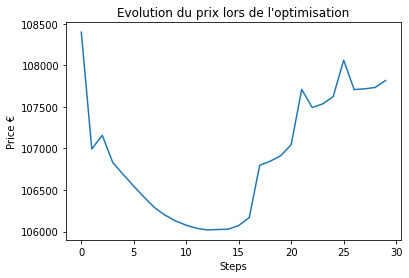

HTA pointe fixe CU
HTA pointe fixe CU
Total cost 3,829.05€ dont fixe 526.68€ , energie 3,223.02€ et 79.36€ de dépassement
B [198.0, 198.0, 198.0, 198.0, 198.0] 3829.05


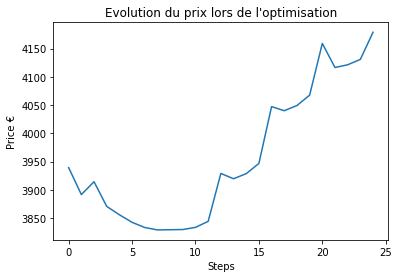

HTA pointe fixe CU
HTA pointe fixe CU
Total cost 4,571.44€ dont fixe 279.3€ , energie 4,223.25€ et 68.9€ de dépassement
C [105.0, 105.0, 105.0, 105.0, 105.0] 4571.44


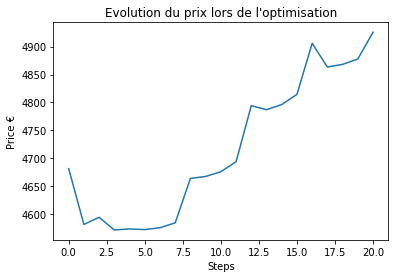

HTA pointe fixe CU
HTA pointe fixe CU
Total cost 5,596.21€ dont fixe 324.52€ , energie 5,223.76€ et 47.93€ de dépassement
D [122.0, 122.0, 122.0, 122.0, 122.0] 5596.21


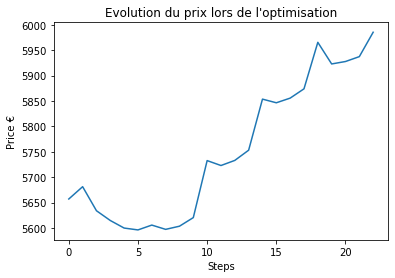

HTA pointe fixe CU
HTA pointe fixe CU
Total cost 11,126.06€ dont fixe 242.06€ , energie 10,877.65€ et 6.34€ de dépassement
E [91.0, 91.0, 91.0, 91.0, 91.0] 11126.06


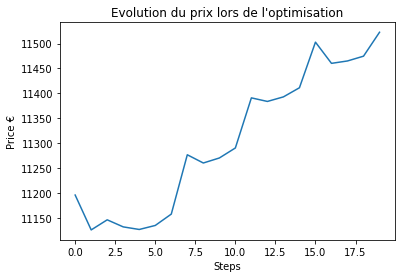

HTA pointe fixe CU
HTA pointe fixe CU
Total cost 21,907.63€ dont fixe 803.32€ , energie 20,912.16€ et 192.16€ de dépassement
F [302.0, 302.0, 302.0, 302.0, 302.0] 21907.63


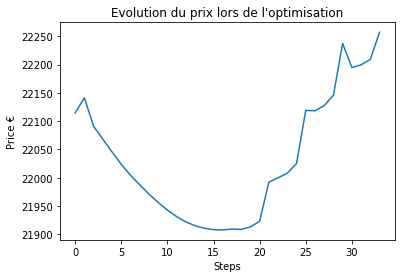

HTA pointe fixe LU
HTA pointe fixe LU
Total cost 20,172.26€ dont fixe 3,702.37€ , energie 16,271.63€ et 198.26€ de dépassement
G [227.0, 227.0, 227.0, 227.0, 227.0] 20172.26


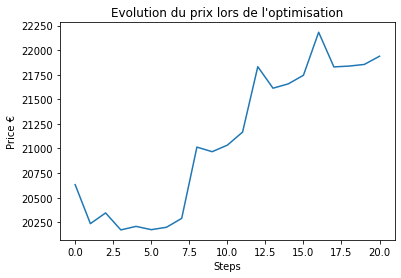

In [22]:
# Cette méthode Brute Force est une première approche naive car il n'est pas possible de minimizer avec scipy automatiquement une fonction non continue d'entiers (PS est une liste d'entiers)

def optimize(letter:str
            ,type_facturation:str
            ,step=10):
    f = lambda PS : compute_total_cost(letter,charges,res,PS=PS,verbose=0,type_facturation=type_facturation)

    PS = [res.loc[letter,'Actuel : Puissance max atteinte Pointe']
                        ,res.loc[letter,'Actuel : Puissance max atteinte HPH']
                        ,res.loc[letter,'Actuel : Puissance max atteinte HCH']
                        ,res.loc[letter,'Actuel : Puissance max atteinte HPE']
                        ,res.loc[letter,'Actuel : Puissance max atteinte HCE']
          ] 
    
    #DEBUG
    
    dirs = [step,-step,0]
    for k in range(1,5):
        if PS[k]<PS[k-1]:
            PS[k]=PS[k-1]
    start = f(PS)
    evo,params =[start],[PS]
    i,j = 0,0
    new = 0
    optimize = True
    
    #Optimise PS1
    while j<2:
        PS[0]+=dirs[j]
        for k in range(1,5):
            PS[k]=PS[0]
        new = f(PS)
        evo.append(new)
        params.append(PS)
        #print(PS,new,start)
        if new > start :
            PS[0]-=dirs[j]
            j+=1
        if new <= start : 
            start = new
            
    j=0
    for k in range(1,5):
        if PS[k]<PS[i]:
            PS[k]=PS[i]
    #print("PS1 optimized")
    #print(start,PS,f(PS))
    
    
    # optimize PS2
    
    PS = [PS[0] for i in range(5)]
    
    
    for i in range(1,5):
        BEST_PS=PS
        optimize = True
        while optimize == True:
            for step in [1,5,10,50]:
                PS[i]+=step
                for k in range(i,5):
                    if PS[k]<PS[i]:
                        PS[k]=PS[i]
                        
                new = f(PS)
                #print(PS,new,start)
                evo.append(new)
                params.append(PS)
                #print(PS,new,start)
            
            new = min(evo[-4:])
            
            #print(start)
            #print(evo[-4:])
            #print(params[-4:])
            
            if new > start :
                PS[i]-=step
                PS = BEST_PS
                optimize=False
            if new <= start : 
                start = new
                print(params[evo.index(new)],evo.index(new))
                PS = params[evo.index(new)]


    
    return evo,params


for letter in ["A","B","C","D","E","F","G"]:
    type_facturation=best_facturation[letter]["facturation"]
    print(type_facturation)
    evo,params = optimize(letter,type_facturation,step=10)
    PS = params[evo.index(min(evo))]
    new_price= compute_total_cost(letter,charges,res,PS=PS
                              ,verbose=1,type_facturation=type_facturation
                              )
    print(letter,PS
          ,new_price
         )
    #print("old price ", best_facturation[letter]["price"])
    
    res.loc[letter,"Préconisation : tarif"]=type_facturation
    res.loc[letter,"Préconisation : Facture glissante (€ HT)"]=new_price
    res.loc[letter,"Puissance souscrite pointe optimisée (kVA C4 / kW C3-C1)"]=PS[0]
    res.loc[letter,"Puissance souscrite hph optimisée (kVA C4 / kW C3-C1)"]=PS[1]
    res.loc[letter,"Puissance souscrite hch optimisée (kVA C4 / kW C3-C1)"]=PS[2]
    res.loc[letter,"Puissance souscrite hpe optimisée (kVA C4 / kW C3-C1)"]=PS[3]
    res.loc[letter,"Puissance souscrite hce optimisée (kVA C4 / kW C3-C1)"]=PS[4]
    res.loc[letter,"Gains euros"]=res.loc[letter,"Actuel : Facture glissante (€ HT)"]-new_price
    
    
    
    plt.plot(evo) 
    plt.xlabel("Steps")
    plt.ylabel("Price €")
    plt.title("Evolution du prix lors de l'optimisation")
    plt.show()

In [27]:
res

,Code postal,Date de début,Date de fin,Actuel : tarif,Actuel : Facture glissante (€ HT),Actuel : Puissance souscrite POINTE,Puissance souscrite hph actuelle (kVA C4 / kW C3-C1),Puissance souscrite hch actuelle (kVA C4 / kW C3-C1),Puissance souscrite hpe actuelle (kVA C4 / kW C3-C1),Puissance souscrite hce actuelle (kVA C4 / kW C3-C1),...,Consommation kwh hph réelle,Actuel : Consommation POINTE (kWh),Préconisation : tarif,Préconisation : Facture glissante (€ HT),Puissance souscrite pointe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hph optimisée (kVA C4 / kW C3-C1),Puissance souscrite hch optimisée (kVA C4 / kW C3-C1),Puissance souscrite hpe optimisée (kVA C4 / kW C3-C1),Puissance souscrite hce optimisée (kVA C4 / kW C3-C1),Gains euros
meter_id,,,,,,,,,,,,,,,,,,,,,
B,39015,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,10318.37,500,500,500,500,500,...,2.994567e+04,8063.166667,HTA pointe fixe CU,3829.05,198.0,198.0,198.0,198.0,198.0,6489.32
D,58220,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,5703.59,130,130,130,130,130,...,5.346917e+04,14194.000000,HTA pointe fixe CU,5596.21,122.0,122.0,122.0,122.0,122.0,107.38
A,58000,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,111651.36,1530,1530,1530,1710,1710,...,1.114749e+06,233570.166667,HTA pointe fixe LU,106020.38,1241.0,1241.0,1241.0,1241.0,1241.0,5630.98
G,25600,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,21164.63,300,300,300,300,300,...,2.002252e+05,42837.333333,HTA pointe fixe LU,20172.26,227.0,227.0,227.0,227.0,227.0,992.37
C,58230,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe CU,4843.89,61,61,61,61,61,...,4.323550e+04,10488.833333,HTA pointe fixe CU,4571.44,105.0,105.0,105.0,105.0,105.0,272.45
E,25290,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe CU,11661.10,123,123,350,350,350,...,8.186783e+04,17311.166667,HTA pointe fixe CU,11126.06,91.0,91.0,91.0,91.0,91.0,535.04
F,90000,2022-03-23 00:00:00,2023-02-23 23:50:00,HTA pointe fixe LU,26085.93,66,410,410,410,410,...,1.742085e+05,21112.000000,HTA pointe fixe CU,21907.63,302.0,302.0,302.0,302.0,302.0,4178.30


In [26]:
res.to_excel("template_updated.xlsx")

# Conclusion

La méthode d'optimisation employée est limité par son pas est ne peut aboutir à des résultats très satisfaisant.  
On obtient une minimisation de tout les $PS_i$ en même temps
Pour aller plus loin :
* tester d'autres méthodes [Scipy continuous methods](https://docs.scipy.org/doc/scipy/reference/optimize.html)
* Avoir des données labelisées pour vérifier les résultats des fonctions de calculs de couts 
* Prendre en compte une possible augmentation des besoins d'energie d'une année à l'autres (5-15%) et proposer un tarif et des seuils optimisés pour cette augmentation